# Custom Chatbot Project

**Atilio Ciuffolini**

TODO: In this cell, write an explanation of which dataset you have chosen and why it is appropriate for this task

The primary objective is to develop a cutting-edge chatbot tailored for providing technical support and sales assistance in the animal agriculture domain, with a particular emphasis on beef cattle nutrition.  
This project strategically utilizes authoritative sources, primarily targeting the 'Nutrient Requirements of Beef Cattle: Eighth Revised Edition (2016).' However, due to the unavailability of a digital version of this edition, we have opted to use the 'Seventh Revised Edition: Update 2000,' from which we extracted the mineral nutrition chapter. This decision allows us to showcase the application of Retrieval-Augmented Generation (RAG) and ML-Driven Prompt Engineering in creating a chatbot that functions as an expert beef nutritionist assistant, utilizing data from the National Academies of Sciences, Engineering, and Medicine.  
This initiative represents the foundational step towards harnessing advanced technologies for enhancing knowledge dissemination and support within this sector.


In [1]:
from PIL import Image

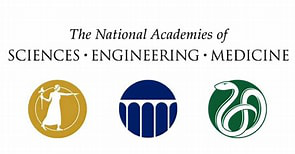

In [2]:
from IPython.display import Image as DisplayImage
DisplayImage(filename="C:\\Users\\Atilio\\anaconda3\\th.png")

In [3]:
# Import necessary Lybraries 
import os
import openai
from openai import OpenAI
from PyPDF2 import PdfReader, PdfWriter
from PyPDF2 import PdfReader
import pandas as pd
import numpy as np

In [4]:
#import tiktoken
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [5]:
# initializing the API client for request to OpenAI
client = OpenAI()

# Step 1: Prepare Dataset

In [6]:
def extract_chapter(pdf_path, start_page, end_page, output_pdf_path):
    """
    Extracts a chapter from a PDF file and saves it to a new PDF file.

    Parameters:
    - pdf_path: Path to the input PDF file.
    - start_page: The starting page number of the chapter (1-indexed).
    - end_page: The ending page number of the chapter (1-indexed).
    - output_pdf_path: Path to the output PDF file where the chapter will be saved.
    """
    # Create a PDF reader object
    reader = PdfReader(pdf_path)

    # Create a PDF writer object for the output
    writer = PdfWriter()

    # Adjust for 0-indexed page numbers
    start_page -= 1
    end_page -= 1

    # Extract the range of pages for the chapter
    for page_number in range(start_page, end_page + 1):
        writer.add_page(reader.pages[page_number])

    # Write the extracted pages to a new PDF
    with open(output_pdf_path, 'wb') as output_pdf_file:
        writer.write(output_pdf_file)

# Example usage
pdf_path = r"C:\Users\Atilio\Downloads\9791.pdf"
start_page = 69  # Example starting page (1-indexed)
end_page = 84  # Example ending page (1-indexed)
output_pdf_path = r"C:\Users\Atilio\anaconda3\envs\envs\LangChain\LLMAppsUdemy/nrc_minerals.pdf"

extract_chapter(pdf_path, start_page, end_page, output_pdf_path)


In [7]:
# Replace with the correct path to your PDF file within this environment
pdf_path = r"C:\Users\Atilio\anaconda3\envs\envs\LangChain\LLMAppsUdemy\nrc_minerals.pdf"

# Create a PDF reader object
reader = PdfReader(pdf_path)

# Get the number of pages in the PDF
num_pages = len(reader.pages)
print(f"Number of pages: {num_pages}")

# Optionally, print the text from a specific page or range of pages
# Here, we print the text from the first page
#page_num = 0  # Adjust as needed to display a different page (0-indexed)
#if page_num < num_pages:
    #page_text = reader.pages[page_num].extract_text()
    #print(f"Text from page {page_num + 1}:\n{page_text}")
#else:
    #print(f"Page {page_num + 1} is out of range.")


Number of pages: 16


In [8]:
# Get the number of pages in the PDF
num_pages = len(reader.pages)
print(f"Number of pages: {num_pages}")

# Iterate through all pages and print their text
for page_num in range(num_pages):
    page_text = reader.pages[page_num].extract_text()
    print(f"Text from page {page_num + 1}:\n{page_text}\n---\n")

Number of pages: 16
Text from page 1:
Nutrient Requirements of Beef Cattle: Seventh Revised Edition: Update 2000
Copyright National Academy of Sciences. All rights reserved.About this PDF file: This new digital representation of the original work has been recomposed from XML files created from the o riginal paper book, not from the original typesetting files. Page
breaks are true to the original; line lengths, word breaks, heading styles, and other typesetting-specific formatting, however , cannot be retained, and some typographic errors may have been
accidentally inserted. Please use the print version of this publication as the authoritative version for attribution.
54At least 17 minerals are required by beef cattle. This
chapter presents information about not only mineralrequirements but also the function, signs of deficiency,factors affecting requirements, sources, and toxicity ofeach essential mineral. Macrominerals required includecalcium, magnesium, phosphorus, potassium, sodium 

## Data Wrangling

TODO: In the cells below, load your chosen dataset into a `pandas` dataframe with a column named `"text"`. This column should contain all of your text data, separated into at least 20 rows.

## Loading and Wrangling Data

**The data should be loaded into a pandas `DataFrame` called `df` where each row represents a text sample, and there is only one column, `"text"`, which contains the raw text data.**

In [9]:
# Assuming CharacterTextSplitter is defined elsewhere or similar functionality
class CharacterTextSplitter:
    def __init__(self, separator, chunk_size, chunk_overlap, length_function):
        self.separator = separator
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.length_function = length_function

    def split_text(self, text):
        chunks = []
        current_pos = 0
        while current_pos < len(text):
            # If not the first chunk, overlap with the previous chunk
            start_pos = max(0, current_pos - self.chunk_overlap)
            end_pos = min(current_pos + self.chunk_size, len(text))
            chunks.append(text[start_pos:end_pos])
            current_pos += self.chunk_size
        return chunks

# Your PDF path
pdf_path = r"C:\Users\Atilio\anaconda3\envs\envs\LangChain\LLMAppsUdemy\nrc_minerals.pdf"

# Read the PDF
reader = PdfReader(pdf_path)
full_text = " ".join([page.extract_text() or "" for page in reader.pages])

# Initialize the text splitter
textsplitter = CharacterTextSplitter("\n", 1000, 200, len)

# Split the text into chunks
text_chunks = textsplitter.split_text(full_text)

# Create a DataFrame with the text chunks
df = pd.DataFrame(text_chunks, columns=['text'])

# Verify the DataFrame contents
print(df.head())


                                                text
0  Nutrient Requirements of Beef Cattle: Seventh ...
1  y,factors affecting requirements, sources, and...
2  fficient in diets fed to cattle,and supplement...
3  .10 0.10 10.00\nCopper mg/kg 10.00 10.00 10.00...
4  t version of this publication as the authorita...


## Generating Embeddings

We'll use the `Embedding` tooling from OpenAI [documentation here](https://platform.openai.com/docs/guides/embeddings/embeddings) to create vectors representing each row of our custom dataset.

In [10]:
from openai import OpenAI
client = OpenAI()

EMBEDDING_MODEL_NAME = "text-embedding-ada-002"
batch_size = 100
embeddings = []
for i in range(0, len(df), batch_size):
    texts = df.iloc[i:i+batch_size]["text"].replace("\n", " ").tolist()
    response = client.embeddings.create(
        input=texts,
        model=EMBEDDING_MODEL_NAME
    )
    # Correctly accessing the embeddings from the response
    embeddings.extend([embedding.embedding for embedding in response.data])

# Assuming df is your DataFrame and it has a 'text' column
df["embeddings"] = embeddings


In [11]:
df.to_csv("embeddings.csv")
df

,text,embeddings
0,Nutrient Requirements of Beef Cattle: Seventh ...,"[0.0011821024818345904, -0.009956623427569866,..."
1,"y,factors affecting requirements, sources, and...","[0.0018214026931673288, -0.010575033724308014,..."
2,"fficient in diets fed to cattle,and supplement...","[-0.005912939552217722, 0.004330318886786699, ..."
3,.10 0.10 10.00\nCopper mg/kg 10.00 10.00 10.00...,"[3.490394738037139e-05, -0.021736254915595055,..."
4,t version of this publication as the authorita...,"[0.0029424719978123903, -0.020504523068666458,..."
...,...,...
84,d in calves with a genetic disorder thatcauses...,"[-0.018119676038622856, -0.011202812194824219,..."
85,", providedthat dietary zinc is present in a fo...","[0.007382276002317667, -0.006167221814393997, ..."
86,"lable data, zinc in the sulfateand oxide form ...","[-0.004222254268825054, -0.018254056572914124,..."
87,"gh, and D.M.Blackmon. 1987.\nEffects of varyin...","[-0.011148697696626186, -0.025029918178915977,..."


In [12]:
# import openai
# openai.api_key = "YOUR API KEY"
df = pd.read_csv("embeddings.csv", index_col=0)
df["embeddings"] = df["embeddings"].apply(eval).apply(np.array)

## Step 0: Inspecting Non-Customized Results

Before we perform any prompt engineering, **let's ask the OpenAI model some questions and see how it answers**.

(If you encounter an `AuthenticationError` when running this code, make sure that you have added a valid API key to the cell above and executed it.)

### First Question Non-Customized

In [13]:
from openai import OpenAI
client = OpenAI()

general_model_prompt = """
Question: ""Whats the copper requeriment for beef cattle?""
Answer:
"""
response = client.completions.create(
  model="gpt-3.5-turbo-instruct",
  prompt=general_model_prompt,
  max_tokens=300,
)
initial_first_answer = response.choices[0].text.strip()
print(initial_first_answer)


The recommended dietary copper requirement for beef cattle varies depending on their age and the stage of production (i.e. growing, maintenance, lactation). However, a general guideline is 8-12 mg of copper per kilogram of dry matter in the diet for cattle over 6 months of age. This requirement may increase for cattle in production, such as those undergoing growth or lactation, and may require supplementation in areas where copper deficiencies are common. It is always best to consult with a veterinarian or animal nutritionist to determine the specific copper requirement for your beef cattle.


### Second Question Non-Customized

In [14]:
general_model_prompt = """
Question: ""Whats the zinc requirement for beef cattle?""
Answer:
"""
response = client.completions.create(
  model="gpt-3.5-turbo-instruct",
  prompt=general_model_prompt,
  max_tokens=300,
)
initial_second_answer = response.choices[0].text.strip()
print(initial_second_answer)

The zinc requirement for beef cattle can vary depending on the stage of production and the age of the cattle. However, on average, it is recommended that beef cattle consume approximately 30-40 mg of zinc per head per day. This can be supplemented through their feed or through mineral supplements. It is important to consult with a veterinarian or nutritionist to determine the specific zinc requirements for your herd.


In order to avoid a `RateLimitError` we'll send our data in batches to the `Embedding.create` function.

In order to avoid having to run that code again in the future, we'll save the generated embeddings as a CSV file.

In [39]:
#! ls

# Step 2: Create a Function that Finds Related Pieces of Text for a Given Question

What we are implementing here is similar to a search engine or recommendation algorithm. We want to sort all of the rows of our dataset from least relevant to most relevant.

This will use the embeddings that we generated previously in order to compare the vectorized version of our question to the vectorized versions of the rows of the dataset.

#### Function to call the comparison of the question embedding with the database enbeddings trhought the cosine similarity method for semantic similarity search working fine, using the API New search

In [17]:
from openai import OpenAI
import numpy as np
import pandas as pd

client = OpenAI()

def cosine_similarity(vec_a, vec_b):
    vec_a = np.array(vec_a).flatten()
    vec_b = np.array(vec_b).flatten()
    return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

def get_rows_sorted_by_relevance(question, df, model_name="text-embedding-ada-002"):
    """
    Sorts DataFrame rows based on their relevance to a given question.
    
    :param question: Question string to compare against DataFrame rows.
    :param df: DataFrame containing rows of text and associated embeddings.
    :param model_name: Model used for generating embeddings.
    :return: DataFrame sorted by relevance to the question.
    """
    # Generate question embedding
    response = client.embeddings.create(input=question, model=model_name)
    #question_embeddings = np.array([embedding['embedding'] for embedding in response['data']])[0]
    #question_embeddings = np.array(response['data'][0].embedding)
    question_embeddings = [embedding.embedding for embedding in response.data]

    
    # Calculate cosine similarities
    df_copy = df.copy()
    df_copy["similarities"] = df_copy["embeddings"].apply(lambda x: cosine_similarity(x, question_embeddings))
    
    # Sort DataFrame by similarities
    df_sorted = df_copy.sort_values(by="similarities", ascending=False)
    
    return df_sorted

# Example usage (ensure your DataFrame 'df' has an 'embeddings' column)
# sorted_df = get_rows_sorted_by_relevance("When did Russia invade Ukraine?", df)
# print(sorted_df.head(10))


Let's test that out for a couple different questions:

In [18]:
get_rows_sorted_by_relevance('Whats the copper requeriment in finishing diets for beef cattle?',df)

,text,embeddings,similarities
48,5\nmg/kg depending largely on the concentratio...,"[-0.0021257095504552126, -0.0132626136764884, ...",0.903335
50,copper-dependent enzymes. In cattle grazing pa...,"[-0.009816667065024376, -0.010950650088489056,...",0.873429
55,the authoritative version for attribution.64 ...,"[-0.00590234249830246, -0.006683288142085075, ...",0.867399
64,"agesare high in iron, dietary copper may need ...","[-0.01277123298496008, -0.023914100602269173, ...",0.862330
3,.10 0.10 10.00\nCopper mg/kg 10.00 10.00 10.00...,"[3.490394738037139e-05, -0.021736254915595055,...",0.860803
...,...,...,...
79,possibly other signs of selenium deficiency.\...,"[-0.017368003726005554, -0.013072763569653034,...",0.772358
75,veshave reduced neutrophil activity (Boyne and...,"[-0.0013387816725298762, -0.031817905604839325...",0.768492
58,goitrogensis more difficult to reverse with i...,"[-0.0047403788194060326, -0.002597960643470287...",0.762014
10,"bone are in a dynamic state, high demands on c...","[0.0016358011635020375, -0.017825601622462273,...",0.760890


## Custom Query Completion

TODO: In the cells below, compose a custom query using your chosen dataset and retrieve results from an OpenAI `Completion` model. You may copy and paste any useful code from the course materials.

# Step 3: Create a Function that Composes a Text Prompt

Building on that sorted list of rows, we're going to select the create a text prompt that provides context to a `Completion` model in order to help it answer a question. The outline of the prompt looks like this:

```
Answer the question based on the context below, and if the
question can't be answered based on the context, say "I don't
know"

Context:

{context}

---

Question: {question}
Answer:
```

We want to fit as much of our dataset as possible into the "context" part of the prompt without exceeding the number of tokens allowed by the `Completion` model, which is currently 4,000. So we'll loop over the dataset, counting the tokens as we go, and stop when we hit the limit. Then we'll join that list of text data into a single string and add it to the prompt.

Answer the question based on the context below as a Beef Nutritionist, then go in your own training knodladge and if the question
can't be answered based on the context complement with knodladge, say "I don't know"

In [19]:
import tiktoken

def create_prompt(question, df, max_token_count):
    """
    Given a question and a dataframe containing rows of text and their
    embeddings, return a text prompt to send to a Completion model
    """
    # Create a tokenizer that is designed to align with our embeddings
    tokenizer = tiktoken.get_encoding("cl100k_base")
    
    # Count the number of tokens in the prompt template and question
    prompt_template = """
    As a Beef Nutritionist, answer the question based on the context provided below. Utilize your specialized training and knowledge.
    If the answer cannot be fully determined from the context, complement it with your expertise. 
    Should the information be insufficient to formulate an answer, please state "I don't know."

Context: 

{}

---

Question: {}
Answer:"""
    
    current_token_count = len(tokenizer.encode(prompt_template)) + \
                            len(tokenizer.encode(question))
    
    context = []
    for text in get_rows_sorted_by_relevance(question, df)["text"].values:
        
        # Increase the counter based on the number of tokens in this row
        text_token_count = len(tokenizer.encode(text))
        current_token_count += text_token_count
        
        # Add the row of text to the list if we haven't exceeded the max
        if current_token_count <= max_token_count:
            context.append(text)
        else:
            break

    #return prompt_template.format("\n\n###\n\n".join(context), question)
    return prompt_template.format("\n\n---\n\n".join(context), question)

    

### Now let's test that out! We'll use a `max_token_count` below the actual limit just to keep the output shorter and more readable.

In [20]:
print(create_prompt("What's the copper requeriment for beef cattle?", df, 350))


    As a Beef Nutritionist, answer the question based on the context provided below. Utilize your specialized training and knowledge.
    If the answer cannot be fully determined from the context, complement it with your expertise. 
    Should the information be insufficient to formulate an answer, please state "I don't know."

Context: 

5
mg/kg depending largely on the concentration of dietarymolybdenum and sulfur. The recommended concentrationof copper in beef cattle diets is 10 mg Cu/kg diet. Thisamount should provide adequate copper if the diet doesnot exceed 0.25 percent sulfur and 2 mg Mo/kg diet. Lessthan 10 mg Cu/kg diet may meet requirements of feedlotcattle because copper is more available in concentratediets than in forage diets. Copper requirements may beaffected by breed. Simmental cattle excrete more copperin their bile than Angus (Gooneratne et al., 1994). Wardet al. (1995) reported that Simmental and Charolais cowsand their calves were more susceptible to copper defic

## Custom Performance Demonstration

TODO: In the cells below, demonstrate the performance of your custom query using at least 2 questions. For each question, show the answer from a basic `Completion` model query as well as the answer from your custom query.

### Step 4: Create a Function that Answers a Question

Our final step is to send that text prompt to a `Completion` model and parse the model output!

In [34]:
COMPLETION_MODEL_NAME = "gpt-3.5-turbo-instruct"

def answer_question(
    question, df, max_prompt_tokens=1800, max_answer_tokens=300
):
    """
    Given a question, a dataframe containing rows of text, and a maximum
    number of desired tokens in the prompt and response, return the
    answer to the question according to an OpenAI Completion model
    
    If the model produces an error, return an empty string
    """
    
    prompt = create_prompt(question, df, max_prompt_tokens)
    
    try:
        response = client.completions.create(
            model=COMPLETION_MODEL_NAME,
            temperature=0.4,
            prompt=prompt,
            max_tokens=max_answer_tokens
        )
        #return response["choices"][0]["text"].strip()
        return response.choices[0].text.strip()
    except Exception as e:
        print(e)
        return ""
        

Now that we have all of the code complete, let's test it out!

### Question 1

In [38]:
customh_beef_nutritionist_first_answer = answer_question("Whats the copper requeriment for beef cattle?", df)
print(custom_beef_nutritionist_first_answer)

The recommended concentration of copper in beef cattle diets is 10 mg Cu/kg diet. However, this amount may need to be adjusted depending on factors such as the concentration of dietary molybdenum and sulfur, breed of cattle, and presence of other minerals such as iron and zinc. It is important to monitor copper levels and adjust accordingly to avoid deficiency or toxicity.


### Question 2

In [32]:
custom_beef_nutritionist_second_answer = answer_question("Whats the zinc requeriment for beef cattle?", df)
print(custom_beef_nutritionist_second_answer)

The recommended requirement of zinc in beef cattle diets is 30 mg Zn/kg diet. Factors such as dietary molybdenum and sulfur levels may also affect the amount of zinc required. Additionally, breed and stage of production may also impact zinc requirements. It is important to ensure that the dietary zinc is in a form that can be effectively absorbed by the animal.


Below we compare answers with and without our custom prompt:

In [97]:
from IPython.display import Markdown, display

def print_markdown(text):
    display(Markdown(text))

print_markdown(f"""
**Question:** *What's the copper requirement for beef cattle?*

**Original Answer:** {initial_first_answer}  
**Custom Answer:**   {custom_beef_nutritionist_first_answer}

---

**Question:** *What's the manganese requirement for beef cattle?*

**Original Answer:** {initial_second_answer}  
**Custom Answer:**   {custom_beef_nutritionist_second_answer}
""")



**Question:** *What's the copper requirement for beef cattle?*

**Original Answer:** There is no specific copper requirement for beef cattle as it can vary depending on the individual animal and their diet. However, approximately 10-20 mg of copper per head per day is recommended for beef cattle. It is important to consult a veterinarian or nutritionist to determine the correct amount for your specific herd.  
**Custom Answer:**   The recommended concentration of copper in beef cattle diets is 10 mg Cu/kg diet. This amount should provide adequate copper if the diet does not exceed 0.25 percent sulfur and 2 mg Mo/kg diet. However, copper requirements may be affected by breed and other factors such as molybdenum, sulfur, and iron levels in the diet. It is important to monitor and adjust copper levels in the diet to prevent both deficiency and toxicity.

---

**Question:** *What's the manganese requirement for beef cattle?*

**Original Answer:** The manganese requirement for beef cattle varies based on their age, body weight, and stage of production. Generally, the recommended minimum manganese requirement for beef cattle is 30 milligrams (mg) per kilogram (kg) of dry matter intake (DMI). This equates to approximately 30 mg of manganese per day for a 1,000-pound cow with a DMI of 2.5% of her body weight.

During periods of high production, such as late pregnancy and lactation, the manganese requirement may increase to 40-50 mg per kg of DMI. On the other hand, growing and finishing cattle may require higher levels of manganese, such as 40-60 mg per kg of DMI.

It is important to note that soil conditions and diet composition can also affect the availability of manganese in the feed, so it is recommended to work with a veterinarian or animal nutritionist to determine the specific manganese needs for your beef cattle herd.  
**Custom Answer:**   The manganese requirement for beef cattle varies depending on their stage of production. For growing and finishing cattle, the recommended concentration of manganese in the diet is 20 mg/kg. For breeding cattle, the recommended concentration is 40 mg/kg. Additionally, manganese requirements may be affected by factors such as breed, dietary factors, and the presence of other minerals such as molybdenum and sulfur. If the diet is not sufficient in manganese, it can result in skeletal abnormalities in young animals and low reproductive performance in older cattle. It is important to regularly assess and adjust the manganese levels in the diet to meet the specific needs of beef cattle.


## Interactive Chatbot

Use a while loop and the built-in input function to allow the user to type questions repeatedly rather than having to edit the content of strings in the code cells

In [98]:
from IPython.display import display, Markdown
COMPLETION_MODEL_NAME = "gpt-3.5-turbo-instruct"

def answer_question_interactive(df, max_prompt_tokens=1800, max_answer_tokens=300):
    """
    Interactively prompts the user for questions, generates prompts based on the
    dataframe containing rows of text, and uses an OpenAI Completion model to return answers.
    Loops until the user decides to exit.
    """
    while True:
        question = input("Please type your question (or type 'exit' to quit): ")
        if question.lower() == 'exit':
            print("Exiting. Thank you for using the chatbot.")
            break

        prompt = create_prompt(question, df, max_prompt_tokens)

        try:
            response = client.completions.create(
                model=COMPLETION_MODEL_NAME,
                prompt=prompt,
                max_tokens=max_answer_tokens
            )
            # Display the question using Markdown for bold formatting
            display(Markdown(f"**Question:** {question}"))
            # Display the answer using Markdown for bold formatting
            display(Markdown(f"**Answer:** {response.choices[0].text.strip()}"))
        except Exception as e:
            print("Error generating response:", e)

# Assuming 'df' is your DataFrame and 'create_prompt' is a function you've defined
# to generate prompts based on the question and the DataFrame content
# answer_question_interactive(df)


In [100]:
# Assuming 'df' is your DataFrame with the text data related to cattle and mineral requirements
# Ensure 'create_prompt' and 'client' are properly defined and configured

# Start the interactive session
answer_question_interactive(df)

# When prompted, enter: "What's the detailed zinc requirement for beef cattle?"
# The function will process the question and return the answer based on your setup.


Please type your question (or type 'exit' to quit):  Analize the sulfur antagonism with the rest o mineral


**Question:** Analize the sulfur antagonism with the rest o mineral

**Answer:** Sulfur antagonism refers to the negative influence that sulfur has on the utilization and absorption of other minerals, such as copper. This is due to the interaction of sulfur and other minerals in the rumen, leading to the formation of thiomolybdates that can bind to copper and decrease its availability for metabolic functions. Additionally, high levels of sulfur can also decrease microbial protein synthesis and cause impaired utilization of lactate, ultimately affecting the overall health and performance of ruminant animals. Therefore, careful consideration of sulfur levels and supplementation is crucial in formulating balanced mineral requirements for livestock.

Please type your question (or type 'exit' to quit):  whats the sulfur leves in the diets that generate those problems


**Question:** whats the sulfur leves in the diets that generate those problems

**Answer:** The sulfur levels in the diets that can generate those problems vary, but it is generally recommended to aim for a concentration of 0.15 percent sulfur in beef cattle diets. However, diets high in urea or other nonprotein nitrogen sources may require additional sulfur supplementation. Additionally, certain forages and crops such as sorghum or sorghum×sudangrass grown in sulfur-deficient soils may be inherently low in sulfur and may require supplementation. Sulfur can be supplemented in ruminant diets through various sources such as sodium sulfate, ammonium sulfate, calcium sulfate, potassium sulfate, magnesium sulfate, or elemental sulfur. It is important to carefully monitor the sulfur levels in diets and consult with a nutritionist to avoid potential toxicity and negative effects on animal health.

Please type your question (or type 'exit' to quit):  sulfur can create polioencephalomalacia explain


**Question:** sulfur can create polioencephalomalacia explain

**Answer:** Sulfur has not been directly linked to the condition known as polioencephalomalacia in beef cattle. However, high levels of sulfur in the diet can lead to a thiamine deficiency, which may increase the risk of polioencephalomalacia. Additionally, sulfur toxicity can lead to neurological symptoms, which could potentially be mistaken for polioencephalomalacia. More research is needed to fully understand the role of sulfur in this condition.

Please type your question (or type 'exit' to quit):  exit


Exiting. Thank you for using the chatbot.


## Conclusions

Upon executing the code, it was observed that custom bots slightly outperformed proprietary LLMs in delivering precise, technically specific responses, highlighting their effectiveness in specialized contexts. Despite this, open-source LLMs emerge as a cost-efficient solution for expansive application deployment, where the meticulous selection of up-to-date, relevant database information is critical for maximizing utility. Integrating fine-tuning with RAG, alongside harnessing both foundational and cutting-edge knowledge via smaller, open-source models, appears to offer the best equilibrium in terms of performance on edge devices. This balance will probably reflects on adoption rates, scalability, practical utility, and cost-efficiency, emphasizing the ongoing evolution of proprietary knowledge bases and the potentially more significant disparities in smaller, open-source models. This situation necessitates continued R&D to capitalize on these advancements fully.